### 0. Importing Modules

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.stats import sem
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import MinMaxScaler

### 1. Importing Data

In [146]:
df = pd.read_csv('data_retention.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Employee Number             1470 non-null   int64 
 1   Retention                   1470 non-null   int64 
 2   Age                         1470 non-null   int64 
 3   Gender                      1470 non-null   int64 
 4   Education                   1470 non-null   int64 
 5   Marital Status              1470 non-null   object
 6   Distance From Home          1470 non-null   int64 
 7   Hourly Rate                 1470 non-null   int64 
 8   Daily Rate                  1470 non-null   int64 
 9   Monthly Rate                1470 non-null   int64 
 10  Monthly Income              1470 non-null   int64 
 11  Percent Salary Hike         1470 non-null   int64 
 12  Education Field             1470 non-null   object
 13  Department                  1470 non-null   obje

In [147]:
#Renaming columns - Lowercase and underscore column names
df = df.rename(columns={'BusinessTravel':'Business Travel'})

import re
df = df.rename(columns=lambda col: re.sub(r"\s+", "_", col.lower()))

#Drop 'employee_number' from the Table
df = df.drop(columns=['employee_number'])

df.head()

,retention,age,gender,education,marital_status,distance_from_home,hourly_rate,daily_rate,monthly_rate,monthly_income,...,relationship_satisfaction,environment_satisfaction,work_life_balance,num_companies_worked,total_working_years,years_at_company,job_level,years_since_last_promotion,years_in_current_role,years_with_current_manager
0,0,41,0,2,Single,1,94,1102,19479,5993,...,1,2,1,8,8,6,2,0,4,5
1,1,49,1,1,Married,8,61,279,24907,5130,...,4,3,3,1,10,10,2,1,7,7
2,0,37,1,2,Single,2,92,1373,2396,2090,...,2,4,3,6,7,0,1,0,0,0
3,1,33,0,4,Married,3,56,1392,23159,2909,...,3,4,3,1,8,8,1,3,7,0
4,1,27,1,1,Married,2,40,591,16632,3468,...,4,1,3,9,6,2,1,2,2,2


### 2. Cleaning Data

In [148]:
#Find dupplicates
def find_duplicates(df):
    duplicate_rows = df[df.duplicated()]
    return duplicate_rows

duplicate_rows = find_duplicates(df)
duplicate_rows

,retention,age,gender,education,marital_status,distance_from_home,hourly_rate,daily_rate,monthly_rate,monthly_income,...,relationship_satisfaction,environment_satisfaction,work_life_balance,num_companies_worked,total_working_years,years_at_company,job_level,years_since_last_promotion,years_in_current_role,years_with_current_manager


In [149]:
# Showing all Unique Values in each Column 
def show_all_variable_values(df):
    variable_values = {}
    for column_name in df.columns:
        unique_values = df[column_name].unique()
        variable_values[column_name] = unique_values
    return variable_values

all_variable_values = show_all_variable_values(df)
for column_name, unique_values in all_variable_values.items():
    print(f"Unique values of variable '{column_name}':")
    print(unique_values)
    print()

Unique values of variable 'retention':
[0 1]

Unique values of variable 'age':
[41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]

Unique values of variable 'gender':
[0 1]

Unique values of variable 'education':
[2 1 4 3 5]

Unique values of variable 'marital_status':
['Single' 'Married' 'Divorced']

Unique values of variable 'distance_from_home':
[ 1  8  2  3 24 23 27 16 15 26 19 21  5 11  9  7  6 10  4 25 12 18 29 22
 14 20 28 17 13]

Unique values of variable 'hourly_rate':
[ 94  61  92  56  40  79  81  67  44  84  49  31  93  50  51  80  96  78
  45  82  53  83  58  72  48  42  41  86  97  75  33  37  73  98  36  47
  71  30  43  99  59  95  57  76  87  66  55  32  52  70  62  64  63  60
 100  46  39  77  35  91  54  34  90  65  88  85  89  68  69  74  38]

Unique values of variable 'daily_rate':
[1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673

In [150]:
# Check for Columns Irrelevent Working Experience Data
condition1 = df['years_at_company'] < df['years_since_last_promotion']
condition2 = df['years_at_company'] < df['years_in_current_role']
condition3 = df['total_working_years'] < df['years_at_company']
condition4 = df['years_at_company'] < df['years_with_current_manager']

combined_condition = condition1 | condition2 | condition3 | condition4

result_df = df[combined_condition]

result_df

,retention,age,gender,education,marital_status,distance_from_home,hourly_rate,daily_rate,monthly_rate,monthly_income,...,relationship_satisfaction,environment_satisfaction,work_life_balance,num_companies_worked,total_working_years,years_at_company,job_level,years_since_last_promotion,years_in_current_role,years_with_current_manager


In [151]:
#Check for Salary Variables
filtered_df = df[(24 * df['hourly_rate'] > df['daily_rate']) | 
                  (30 * df['daily_rate'] > df['monthly_rate'])]

filtered_df

,retention,age,gender,education,marital_status,distance_from_home,hourly_rate,daily_rate,monthly_rate,monthly_income,...,relationship_satisfaction,environment_satisfaction,work_life_balance,num_companies_worked,total_working_years,years_at_company,job_level,years_since_last_promotion,years_in_current_role,years_with_current_manager
0,0,41,0,2,Single,1,94,1102,19479,5993,...,1,2,1,8,8,6,2,0,4,5
1,1,49,1,1,Married,8,61,279,24907,5130,...,4,3,3,1,10,10,2,1,7,7
2,0,37,1,2,Single,2,92,1373,2396,2090,...,2,4,3,6,7,0,1,0,0,0
3,1,33,0,4,Married,3,56,1392,23159,2909,...,3,4,3,1,8,8,1,3,7,0
4,1,27,1,1,Married,2,40,591,16632,3468,...,4,1,3,9,6,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,36,1,2,Married,23,41,884,12290,2571,...,3,3,3,4,17,5,2,0,2,3
1466,1,39,1,1,Married,6,42,613,21457,9991,...,1,4,3,4,9,7,3,1,7,7
1467,1,27,1,3,Married,4,87,155,5174,6142,...,2,2,3,1,6,6,2,0,2,3
1468,1,49,1,3,Married,2,63,1023,13243,5390,...,4,4,2,2,17,9,2,0,6,8


In [152]:
# Find Minimum and Maximum Value of each Continuous Column
continuous_column = [
    'age', 
    'distance_from_home', 
    'monthly_income', 
    'percent_salary_hike', 
    'total_working_years', 
    'years_at_company', 
    'years_since_last_promotion', 
    'years_in_current_role', 
    'years_with_current_manager'
]

min_max_values = {}

for column in continuous_column:
    if column in df.columns:
        min_value = df[column].min()
        max_value = df[column].max()
        min_max_values[column] = {'min': min_value, 'max': max_value}
    else:
        print(f"Column '{column}' does not exist in the DataFrame.")

min_max_df = pd.DataFrame(min_max_values).T
min_max_df.reset_index(inplace=True)
min_max_df.columns = ['Column', 'Min', 'Max']

print(min_max_df)

                       Column   Min    Max
0                         age    18     60
1          distance_from_home     1     29
2              monthly_income  1009  19999
3         percent_salary_hike    11     25
4         total_working_years     0     40
5            years_at_company     0     40
6  years_since_last_promotion     0     15
7       years_in_current_role     0     18
8  years_with_current_manager     0     17


### 3. Data Description

In [153]:
def standard_error_skewness(df):
    n = len(df)
    return np.sqrt(6 * n * (n - 1) / ((n - 2) * (n + 1) * (n + 3)))

def standard_error_kurtosis(df):
    n = len(df)
    return np.sqrt((24 * n * (n - 2) * (n - 3)) / ((n + 1) * (n + 3) * (n + 5) * (n + 7)))

numeric_columns = df.select_dtypes(include=[np.number])

statistics = pd.DataFrame()

statistics['count'] = numeric_columns.count()
statistics['mean'] = numeric_columns.mean()
statistics['median'] = numeric_columns.median()
statistics['mode'] = numeric_columns.mode().iloc[0]
statistics['skewness'] = numeric_columns.skew()
statistics['std_err_skewness'] = sem(numeric_columns, axis=0)
statistics['kurtosis'] = numeric_columns.kurtosis()
statistics['std_err_kurtosis'] = sem(numeric_columns**4, axis=0)

statistics

,count,mean,median,mode,skewness,std_err_skewness,kurtosis,std_err_kurtosis
retention,1470,0.838776,1.0,1.0,-1.844366,0.009595,1.403594,9.594613e-03
age,1470,36.923810,36.0,35.0,0.413286,0.238269,-0.404145,6.796300e+04
gender,1470,0.600000,1.0,1.0,-0.408665,0.012782,-1.835492,1.278188e-02
education,1470,2.912925,3.0,3.0,-0.289681,0.026712,-0.559115,3.463312e+00
distance_from_home,1470,9.192517,7.0,2.0,0.958118,0.211443,-0.224833,4.072966e+03
hourly_rate,1470,65.891156,66.0,66.0,-0.032311,0.530233,-1.196398,7.481658e+05
daily_rate,1470,802.485714,802.0,691.0,-0.003519,10.524335,-1.203823,3.561594e+10
monthly_rate,1470,14313.103401,14235.5,4223.0,0.018578,185.646285,-1.214956,3.590923e+15
monthly_income,1470,6502.931293,4919.0,2342.0,1.369817,122.793054,1.005233,8.525617e+14
percent_salary_hike,1470,15.209524,14.0,11.0,0.821128,0.095459,-0.300598,2.076249e+03


### 4. Hypothesis Testing

In [154]:
# Drop unnecessary columns
df = df.drop(columns=['standard_hours', 'hourly_rate', 'daily_rate', 'monthly_rate'])

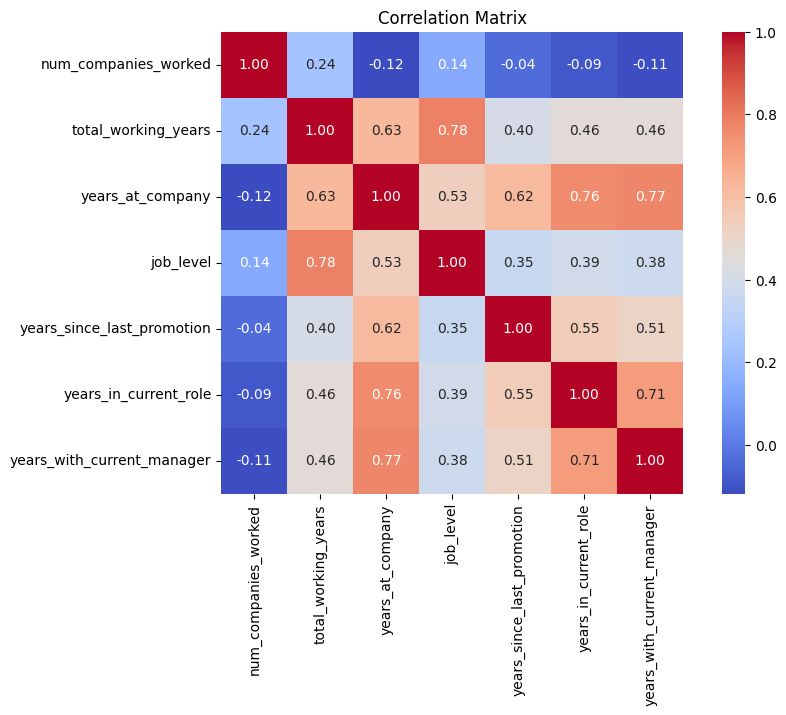

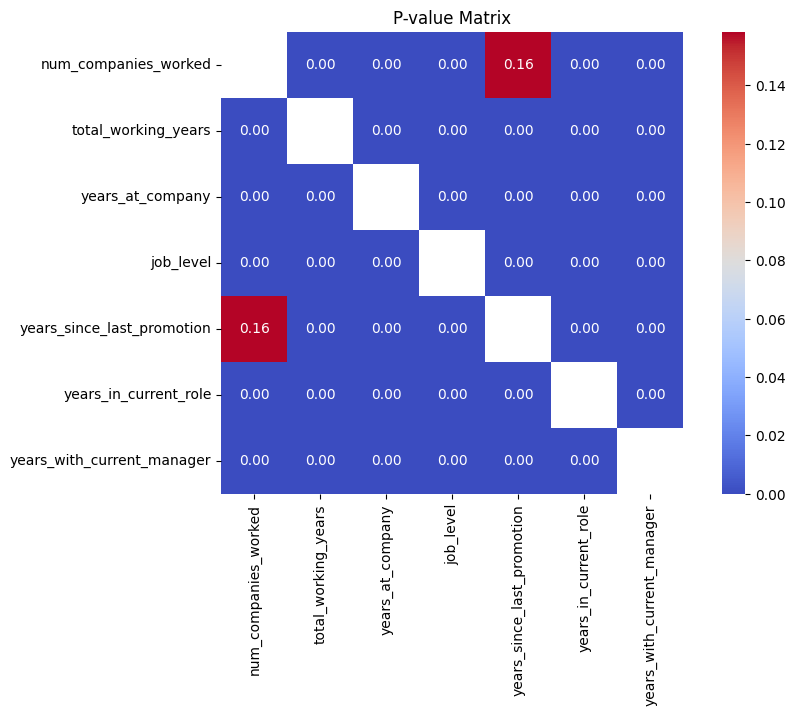

In [155]:
# Correlation Matrix of Work Experience Variables
experience_var = [
    'num_companies_worked',
    'total_working_years', 
    'years_at_company', 
    'job_level', 
    'years_since_last_promotion', 
    'years_in_current_role', 
    'years_with_current_manager'
]

correlation_matrix = df[experience_var].corr()
p_value_matrix = pd.DataFrame(np.zeros_like(correlation_matrix), columns=experience_var, index=experience_var)

for row in experience_var:
    for col in experience_var:
        if row != col:
            corr, p_value = pearsonr(df[row], df[col])
            correlation_matrix.at[row, col] = corr
            p_value_matrix.at[row, col] = p_value
        else:
            p_value_matrix.at[row, col] = np.nan

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(p_value_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('P-value Matrix')
plt.show()

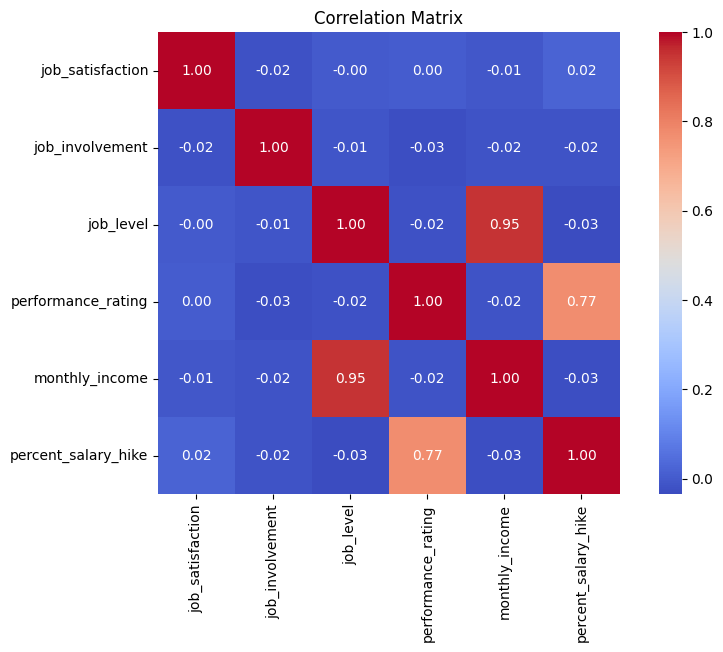

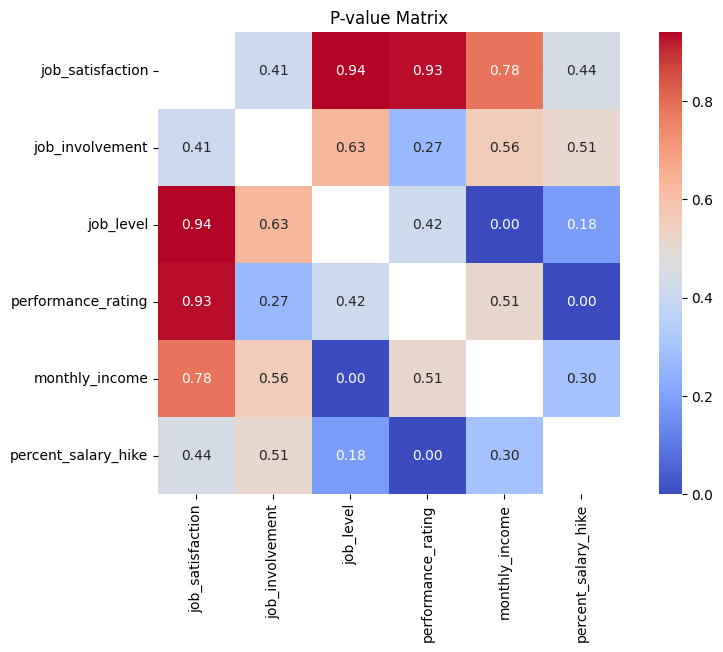

In [156]:
# Correlation Matrix of Job Satisfaction, Involvement and Performance Rating
job_fulfillment = [
    'job_satisfaction',
    'job_involvement',
    'job_level',
    'performance_rating',
    'monthly_income',
    'percent_salary_hike'
]

correlation_matrix = df[job_fulfillment].corr()
p_value_matrix = pd.DataFrame(np.zeros_like(correlation_matrix), columns=job_fulfillment, index=job_fulfillment)

for row in job_fulfillment:
    for col in job_fulfillment:
        if row != col:
            corr, p_value = pearsonr(df[row], df[col])
            correlation_matrix.at[row, col] = corr
            p_value_matrix.at[row, col] = p_value
        else:
            p_value_matrix.at[row, col] = np.nan

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(p_value_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('P-value Matrix')
plt.show()

In [157]:
# Drop Unecessary Variables and Create 'avrg_years_per_comp'
df['num_companies_worked'] += 1
df['avrg_years_per_comp'] = df['total_working_years'] / df['num_companies_worked']
df = df.drop(columns=['total_working_years', 'years_with_current_manager', 'years_at_company', 'job_level', 'performance_rating'])

### 5. Linear Regression Model

In [158]:
# Mapping Categorical Variables
travel_mapping = {
    'Travel_Rarely': 1,
    'Travel_Frequently': 2,
    'Non-Travel': 0
}

df['business_travel'] = df['business_travel'].map(travel_mapping).infer_objects()

marital_status_mapping = {
    'Single': 0,
    'Married': 1,
    'Divorced': 2
}

df['marital_status'] = df['marital_status'].map(marital_status_mapping).infer_objects()

In [159]:
# Create correct_field_of_study
def determine_correct_field(row):
    education = row['education_field']
    job = row['job_role']

    if education == "Other":
        return 1
    elif education in ["Life Science", "Technical Degree", "Medical"] and row['department'] == "R&D":
        return 1
    elif education == "Human Resources" and row['department'] == "Human Resources":
        return 1
    elif education == "Marketing" and row['department'] == "Sales":
        return 1
    elif job == "Manager":
        return 1
    else:
        return 0

df['correct_field_of_study'] = df.apply(determine_correct_field, axis=1)

In [160]:
# Encode 'job_role' variable and Drop 'department' and 'education_field'
df_encoded = pd.get_dummies(df, columns=['job_role'], prefix='role', drop_first=True)

df_encoded = df_encoded.drop(columns=['department', 'education_field'])
df_encoded = df_encoded.astype(int)

# Initial Regression Model
Y = df_encoded['retention']
X = df_encoded.drop(columns=['retention'])

X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              retention   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     15.74
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           6.94e-67
Time:                        19:52:58   Log-Likelihood:                -412.88
No. Observations:                1470   AIC:                             885.8
Df Residuals:                    1440   BIC:                             1045.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [161]:
# Encode 'monthly_income'
scaler = MinMaxScaler()

df_encoded['monthly_income_scaled'] = scaler.fit_transform(df_encoded[['monthly_income']])

df_encoded = df_encoded.drop(columns = ['monthly_income'])

Y = df_encoded['retention']
X = df_encoded.drop(columns=['retention'])

X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              retention   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     15.74
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           6.94e-67
Time:                        19:52:58   Log-Likelihood:                -412.88
No. Observations:                1470   AIC:                             885.8
Df Residuals:                    1440   BIC:                             1045.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [162]:
# Second Model Excluding Insignificant Variables
df_encoded = df_encoded.drop(columns=['education', 'monthly_income_scaled', 'percent_salary_hike', 
                                      'avrg_years_per_comp', 'correct_field_of_study'])

# Final Regression Model
Y = df_encoded['retention']
X = df_encoded.drop(columns=['retention'])

X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              retention   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     19.04
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           7.61e-70
Time:                        19:52:58   Log-Likelihood:                -413.33
No. Observations:                1470   AIC:                             876.7
Df Residuals:                    1445   BIC:                             1009.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [163]:
# Heteroskedasticity test
model = sm.OLS(Y, X).fit()

bp_test = het_breuschpagan(model.resid, model.model.exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_results = dict(zip(labels, bp_test))

print("Breusch-Pagan Test Results:")
for key, value in bp_test_results.items():
    print(f"{key}: {value}")

Breusch-Pagan Test Results:
Lagrange multiplier statistic: 171.74995592879074
p-value: 2.723025585536624e-24
f-value: 7.965167144626535
f p-value: 4.964674140727605e-26


In [164]:
# Final Model using Heteroskedasticity-Consistent standard errors
model_robust = sm.OLS(Y, X).fit(cov_type='HC3')

print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:              retention   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     14.59
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           1.02e-52
Time:                        19:52:58   Log-Likelihood:                -413.33
No. Observations:                1470   AIC:                             876.7
Df Residuals:                    1445   BIC:                             1009.
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [165]:
# VIF check for Multicollinearity
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [sm.OLS(X[col], X.drop(col, axis=1)).fit().rsquared for col in X.columns]

vif_data['VIF'] = 1 / (1 - vif_data['VIF'])

print(vif_data)

                       Variable        VIF
0                         const  96.386763
1                           age   1.377631
2                        gender   1.025382
3                marital_status   1.837186
4            distance_from_home   1.011374
5            stock_option_level   1.812055
6               business_travel   1.013318
7      training_times_last_year   1.023772
8                     over_time   1.028537
9              job_satisfaction   1.010506
10              job_involvement   1.011241
11    relationship_satisfaction   1.017061
12     environment_satisfaction   1.014885
13            work_life_balance   1.018217
14         num_companies_worked   1.160471
15   years_since_last_promotion   1.495919
16        years_in_current_role   1.563739
17         role_Human Resources   1.381528
18   role_Laboratory Technician   2.569298
19                 role_Manager   1.730510
20  role_Manufacturing Director   1.920553
21       role_Research Director   1.557620
22      rol

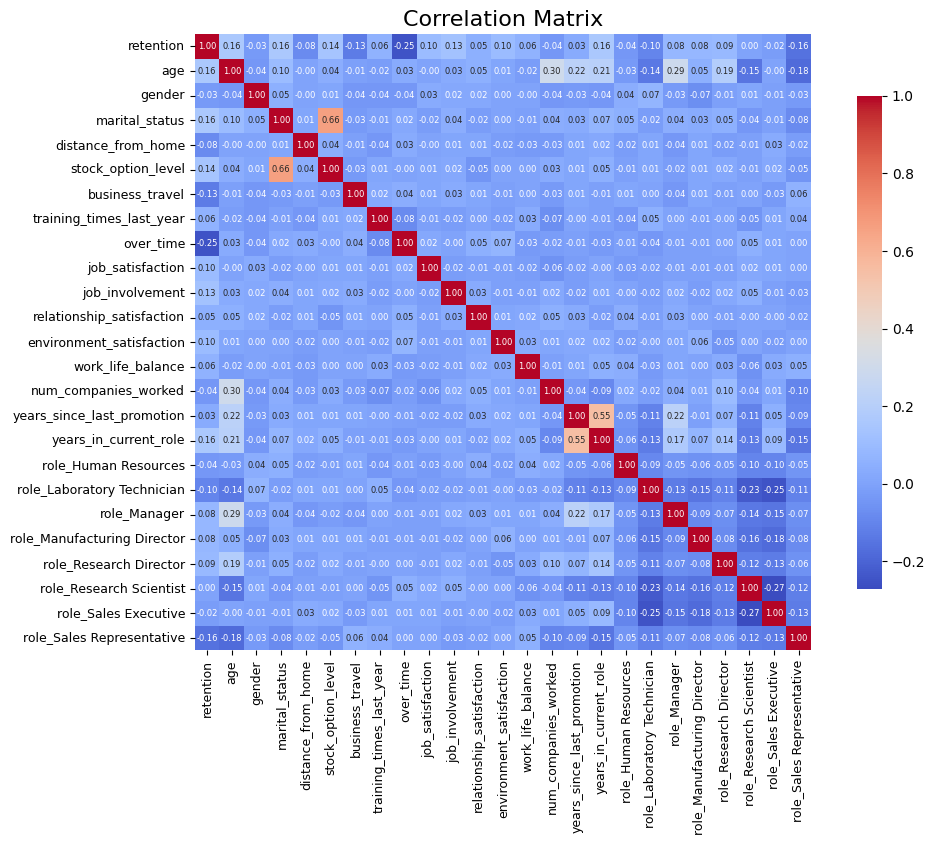

In [166]:
# Correlation Matrix
correlation_matrix = df_encoded.corr().round(2)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, 
            annot_kws={"size": 6})
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()